In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime,timedelta, timezone
import re
import os





In [2]:
# Define the URLs to scrape
urls = ["https://gcaptain.com/", "https://www.seatrade-maritime.com/maritime-news","https://www.offshore-energy.biz/worldmaritimenews/","https://www.marinelink.com/"]

In [3]:
def convert_date(relative_date):
    now = datetime.now(timezone.utc)
    if 'day' in relative_date:
        days_ago = int(re.findall(r'\d+', relative_date)[0])
        date = now - timedelta(days=days_ago)
    elif 'hour' in relative_date:
        hours_ago = int(re.findall(r'\d+', relative_date)[0])
        date = now - timedelta(hours=hours_ago)
    elif 'days ago' in relative_date:
        days_ago = int(re.findall(r'\d+', relative_date)[0])
        date = now - timedelta(days=days_ago)
    elif 'month' in relative_date:
        months_ago = int(re.findall(r'\d+', relative_date)[0])
        # Calculate the approximate number of days in the specified months
        days_ago = months_ago * 30  
        date = now - timedelta(days=days_ago)
    else:
        date = now
    return date.strftime('%Y-%m-%d')

In [4]:
def extract_data_from_gcaptain(url):
    news_results_gcaptain = []
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('article')
    
    for article in articles:
        title = article.find('h3', class_='headline')
        if title is not None:
            title = title.text
        date = article.find('span', class_='date')
        if date is not None:
            date = convert_date(date.text)
        description = article.find('div', class_='p')
        if description is not None:
            description = description.text
        news_results_gcaptain.append((title, date, description, url))

    return pd.DataFrame(news_results_gcaptain, columns=['Title', 'Date', 'Description', 'URL'])




def extract_data_from_seatrade(url):
        news_results_seatrade = []
        response = requests.get(url)    
        response.raise_for_status()  
        soup = BeautifulSoup(response.text, 'html.parser')
        articles = soup.find_all('article')

        for article in articles:
            # Extract the title
            title = article.find('div', class_='title')
            if title is not None:
                title = title.text
            else:
                title = ""

            # Extract the date
            date = article.find('span', class_='date')
            if date is not None:
                date = convert_date(date.text)
            else:
                date = ""
            
            # Extract the description
            description = article.find('div', class_='summary-wrapper')
            if description is not None:
                description = description.text
            else:
                description = ""
            
            title_element = article.find('h3', class_='card-rich__title')
            if title_element:
                link = title_element.find('a', class_='card-rich__link')
                if link:
                    article_url = link['href']
                else:
                    article_url = ""
            else:
                article_url = ""
            
            print(article_url)
            news_results_seatrade.append((title, date, description, article_url))

        return pd.DataFrame(news_results_seatrade, columns=['Title', 'Date', 'Description', 'URL'])


def extract_data_from_offshore(url):
    news_results_offshore = []
    page_num = 1
    while page_num <= 25:
        new_url = url + f'/page/{page_num}/'
        response = requests.get(new_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all('div', class_='card-rich')
        if len(articles) == 0:
            break
        for article in articles:
            title = article.find('h3', class_='card-rich__title')
            
            if title is not None:
                title = title.text.strip()
            date = article.find('div', class_='card-rich__element card-rich__time-ago')
            
            if date is not None:
                date = convert_date(date.text)
            
            link = article.find('a')
            if link is not None:
                article_url = link['href']
                if not article_url.startswith('http'):
                    article_url = 'https://www.offshore-energy.biz' + article_url

                response = requests.get(article_url)
                article_soup = BeautifulSoup(response.content, 'html.parser')
                
                description_container = article_soup.find('div', class_='wp-content')

                if description_container is not None:
                    description = ' '.join([p.text.strip() for p in description_container.find_all('p')])
                else:
                    description = None
            else:
                description = None
           
            news_results_offshore.append((title, date, description, url))
        page_num += 1

    return pd.DataFrame(news_results_offshore, columns=['Title', 'Date', 'Description', 'URL'])


def extract_data_from_marinelink(url):
        news_results_marinelink = []

        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for 4xx and 5xx status codes
        soup = BeautifulSoup(response.text, 'html.parser')
        articles = soup.select(".row")

        for article in articles:
            # Extract the title
            title_element = article.find('h3')
            if title_element is not None:
                title = title_element.text.strip()
            else:
                title = ""

            # Extract the date
            date_element = article.find('div', class_='date')
            if date_element is not None:
                date = convert_date(date_element.text)
            else:
                date = ""

            # Extract the description
            description_element = article.find('p')
            if description_element is not None:
                description = description_element.text.strip()
            else:
                description = ""

            news_results_marinelink.append((title, date, description, url))

        return pd.DataFrame(news_results_marinelink, columns=['Title', 'Date', 'Description', 'URL'])



# List of URLs to scrape
urls = [
    "https://gcaptain.com/",
    "https://www.seatrade-maritime.com/maritime-news",
    "https://www.offshore-energy.biz/category/long-reads/",
    "https://www.marinelink.com/",
    
]

# Create an empty list to store the DataFrames for each URL
dfs = []

# Loop through the URLs and extract data using corresponding functions
for url in urls:
    if "gcaptain" in url:
        df = extract_data_from_gcaptain(url)
    elif "seatrade-maritime" in url:
        df = extract_data_from_seatrade(url)
    elif "offshore-energy" in url:
        df = extract_data_from_offshore(url)
    elif "marinelink" in url:
        df = extract_data_from_marinelink(url)
    else:
        print("Unknown URL:", url)
        continue

    dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
df_combined = pd.concat(dfs, ignore_index=True)

# Print the combined DataFrame
print(df_combined)
df_combined.drop_duplicates(inplace=True)
# Check if the Excel file exists
if os.path.exists("all_results.xlsx"):
    # Load the existing Excel file into a DataFrame
    df_existing = pd.read_excel("all_results.xlsx")
    
    # Combine the existing DataFrame with the newly scraped data
    df_combined = pd.concat([df_existing, df_combined], ignore_index=True)

df_combined.drop_duplicates(inplace=True)
# Save the combined DataFrame to an Excel file
df_combined.to_excel("all_results.xlsx", index=False)


# Filter the news results based on keywords
# Fill missing values in the 'Title' column with an empty string
df_combined['Title'] = df_combined['Title'].fillna('')

# Filter the DataFrame based on keywords
keywords = ["Taiwan", "Taipei port", "China", "Shanghai","Chattogram port","USA","Singapore"
               "Antwerp port", "Shenzhen port","Shanghai port","Colombia port","Le Havre  port","Hamburg/ Bremerhaven port",
                "Hong Kong port","Chennai port","Nhava Sheva port","OOCL","ZIM","Wan Hai","CNC","Dongjin","Heung-A","Jin Jiang",
                "Tuticorin port","Vishakhapatnam port", "Semarang (Via SIN) port","Interasia","Hai Hua","Sinotrans","SITC",
                "Osaka port","Busan port","Singapore port","Maersk","USA","UAE","Misheng","Pan Continental","Nirint","Admiral Container","AC Container",
                "Kaohsiung port","Hong Kong","Colombia","Bangladesh","Belgium","Colombia","France","Germany","Hong Kong","India","Korea","Busan","OOCL/COSCO/MAERSK",
"Isreal","Haifa",
"Indonesia","Jakarta","HAPAG/ ONE",
"Malaysia","Klang",
"Japan","Kobe",
"Singapore","ONE/HAPAG/COSCO"
"ITALY","GENOVA","MAERSK"
"GERMANY","HAMBURG","HAPAG (DHL) / MSC (EFL-CO LOADER)",
"BELGIUM","ANTAWERP","ECU (CO LOADER)",
"TURKEY","ISTANBUL","ONE (CO LOADER )"
]
# Use str.contains() to filter based on 'Title' or 'Description'
filtered_df = df_combined[df_combined['Title'].str.contains('|'.join(keywords), case=False) |
                          df_combined['Description'].str.contains('|'.join(keywords), case=False)]





























                                                 Title        Date  \
0                 \nJoseph Schulte leaves Odessa port   2023-08-16   
1    \nWallenius Wilhelmsen ordering up to 12 PCTCs...  2023-08-16   
2    \nWärtsilä opens lifecycle support centre in S...  2023-08-16   
3    \nAnnual CIC has extra edge as ship fire safet...  2023-08-16   
4    \nBoxships move cargo overland as Panama Canal...  2023-08-16   
..                                                 ...         ...   
647  Maersk orders carbon-neutral methanol-powered ...  2023-08-16   
648  Hydrogen enjoying unprecedented momentum as on...  2023-08-16   
649  Will UK Hydrogen Strategy help shipping to dec...  2023-08-16   
650  Blue Ocean Transfers: A New Jones Act CTV Play...  2023-08-16   
651         Keel Laid for US' First Plug-in Hybrid SOV  2023-08-16   

                                           Description  \
0                                                        
1                 

C:\Users\acer\AppData\Local\Temp\ipykernel_16408\2524759815.py:218: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df = df_combined[df_combined['Title'].str.contains('|'.join(keywords), case=False) |
C:\Users\acer\AppData\Local\Temp\ipykernel_16408\2524759815.py:219: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_combined['Description'].str.contains('|'.join(keywords), case=False)]


In [5]:



print(filtered_df)

                                                  Title        Date  \
1     \nPodcast: In Conversation with Nikeel Idnani ...  2023-07-26   
10    \nPodcast: In Conversation with Nikeel Idnani ...  2023-07-26   
13    \nChina Merchants Port and CMA CGM strengthen ...  2023-07-26   
14    \nCMA CGM Liberty is first LNG-powered boxship...  2023-07-26   
16        \nCyan Renewables buying first SOV from DEME   2023-07-26   
...                                                 ...         ...   
3507  Two UK carbon capture and storage projects sel...  2023-08-16   
3518  Shell exits Permian as energy transition plays...  2023-08-16   
3520  Houston reimagining meaning of energy capital ...  2023-08-16   
3521  Aker BP hands out first major contracts for No...  2023-08-16   
3529  Maersk orders carbon-neutral methanol-powered ...  2023-08-16   

                                            Description  \
1                                                   NaN   
10    \nThis latest episode o

In [6]:
df_combined.drop_duplicates(inplace=True)

# Adding a new column 'Risk' with a value
filtered_df['Risk'] = ""  

# Save the DataFrame to an Excel file
filtered_df.to_excel("Ports_news.xlsx", index=False)

C:\Users\acer\AppData\Local\Temp\ipykernel_16408\3630665023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Risk'] = ""


In [7]:
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# nltk.download('omw-1.4')

# # Download necessary resources for NLTK
# nltk.download('punkt')
# nltk.download('wordnet')

# # Initialize the lemmatizer
# lemmatizer = WordNetLemmatizer()

# # Remove duplicate titles
# filtered_df.drop_duplicates(subset='Title', keep='first', inplace=True)


# # Tokenize and lemmatize the 'Title' and 'Description' columns
# filtered_df['Title'] = filtered_df['Title'].apply(lambda x: word_tokenize(x.lower()) if x is not None else [])
# filtered_df['Description'] = filtered_df['Description'].apply(lambda x: word_tokenize(x.lower()) if x is not None else [])

# filtered_df['Title'] = filtered_df['Title'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# filtered_df['Description'] = filtered_df['Description'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])



<font size="6"> Analysis using textblob</font> 

In [7]:
!pip install textblob


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

nltk.download('omw-1.4')

# Download necessary resources for NLTK
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Remove duplicate titles
filtered_df.drop_duplicates(subset='Title', keep='first', inplace=True)
# Remove duplicate descriptions
filtered_df.drop_duplicates(subset='Description', keep='first', inplace=True)


# Function to tokenize and lemmatize text
def tokenize_and_lemmatize(text):
    if isinstance(text, str):  # Check if the text is not NaN or missing
        words = word_tokenize(text.lower())
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return lemmatized_words
    else:
        return []

# Tokenize and lemmatize the 'Title' and 'Description' columns
filtered_df['Title'] = filtered_df['Title'].apply(tokenize_and_lemmatize)
filtered_df['Description'] = filtered_df['Description'].apply(tokenize_and_lemmatize)

# # Perform Sentiment Analysis using TextBlob
# filtered_df['TitleSentiment'] = filtered_df['Title'].apply(lambda x: TextBlob(" ".join(x)).sentiment.polarity)
# filtered_df['DescriptionSentiment'] = filtered_df['Description'].apply(lambda x: TextBlob(" ".join(x)).sentiment.polarity)


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\acer\AppData\Local\Temp\ipykernel_12076\998804173.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop_duplicates(subset='Title', keep='first', inplace=True)
C:\Users\acer\AppData\Local\Temp\ipykernel_12076\998804173.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

In [9]:
# #DataFrame with the sentiment polarity scores 
# print(filtered_df[['Title', 'TitleSentiment', 'Description', 'DescriptionSentiment']])


In [10]:
# data = filtered_df[['Title', 'TitleSentiment', 'Description', 'DescriptionSentiment']]

# output_file = 'analysis.xlsx'
# data.to_excel(output_file, index=False)

In [11]:
# #summary statistics of the sentiment polarity scores

# title_sentiment_stats = filtered_df['TitleSentiment'].describe()
# description_sentiment_stats = filtered_df['DescriptionSentiment'].describe()

# print("Title Sentiment Summary:")
# print(title_sentiment_stats)

# print("\nDescription Sentiment Summary:")
# print(description_sentiment_stats)


In [12]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# plt.hist(filtered_df['TitleSentiment'], bins=20, alpha=0.5, label='Title Sentiment')
# plt.hist(filtered_df['DescriptionSentiment'], bins=20, alpha=0.5, label='Description Sentiment')
# plt.xlabel('Sentiment Polarity')
# plt.ylabel('Frequency')
# plt.legend()
# plt.title('Sentiment Polarity Distribution')
# plt.show()


<font size="6"> Analysis using Similarity matrix</font> 

In [13]:
# Print the outcome
print(filtered_df['Title'])
print(filtered_df['Description'])


1       [podcast, :, in, conversation, with, nikeel, i...
13      [china, merchant, port, and, cma, cgm, strengt...
14      [cma, cgm, liberty, is, first, lng-powered, bo...
16      [cyan, renewables, buying, first, sov, from, d...
17      [shanghai, international, trade, exceeds, $, 2...
                              ...                        
1497      [offshore, wind, rule, ‒, det, norske, veritas]
1498    [offshore, wind, in, france, –, the, state, of...
1501                              [the, marineco, mariah]
1504                 [grid, ‒, paving, the, way, forward]
1555    [dry, bulk, stock, and, the, dog, day, of, sum...
Name: Title, Length: 421, dtype: object
1                                                      []
13      [the, chinese, port, operator, china, merchant...
14      [the, 15,000, teu, cma, cgm, liberty, ha, beco...
16      [singapore-based, offshore, wind, farm, vessel...
17      [shanghai, 's, total, import, and, export, val...
                              ..

In [14]:
# Step 1: Define a list of keywords related to risks, ports, and vessels
risk_keywords = ['risk','incident','closed', 'danger', 'hazard', 'unsafe', 'accident', 'incident', 'emergency', 'threat']
port_keywords = ['port', 'harbor', 'terminal', 'dock']
vessel_keywords = ['vessel', 'ship', 'boat']

# Step 2: Check if the news description contains keywords related to risks, ports, or vessels
def contains_risk_port_vessel_keywords(lemmatized_description):
    # Combine the lemmatized words into a single string
    description_text = ' '.join(lemmatized_description)

    # Check if any of the keywords related to risks, ports, or vessels are present
    has_risk_keyword = any(keyword in description_text for keyword in risk_keywords)
    has_port_keyword = any(keyword in description_text for keyword in port_keywords)
    has_vessel_keyword = any(keyword in description_text for keyword in vessel_keywords)

    # Return True if any of the keywords related to risks, ports, or vessels are present
    return has_risk_keyword and (has_port_keyword or has_vessel_keyword)

# Apply the function to the 'Description' column to check for risk-related news about ports or vessels
filtered_df['Is_Risk_to_Port_or_Vessel'] = filtered_df['Description'].apply(contains_risk_port_vessel_keywords)

# 
#  True for news articles that contain keywords related to risks about ports or vessels.

#  check the  column to determine which news articles are considered
# to be risks related to ports or vessels.
print(filtered_df[['Title', 'Description', 'Is_Risk_to_Port_or_Vessel']])



                                                  Title  \
1     [podcast, :, in, conversation, with, nikeel, i...   
13    [china, merchant, port, and, cma, cgm, strengt...   
14    [cma, cgm, liberty, is, first, lng-powered, bo...   
16    [cyan, renewables, buying, first, sov, from, d...   
17    [shanghai, international, trade, exceeds, $, 2...   
...                                                 ...   
1497    [offshore, wind, rule, ‒, det, norske, veritas]   
1498  [offshore, wind, in, france, –, the, state, of...   
1501                            [the, marineco, mariah]   
1504               [grid, ‒, paving, the, way, forward]   
1555  [dry, bulk, stock, and, the, dog, day, of, sum...   

                                            Description  \
1                                                    []   
13    [the, chinese, port, operator, china, merchant...   
14    [the, 15,000, teu, cma, cgm, liberty, ha, beco...   
16    [singapore-based, offshore, wind, farm, vessel...

C:\Users\acer\AppData\Local\Temp\ipykernel_12076\3422683900.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Is_Risk_to_Port_or_Vessel'] = filtered_df['Description'].apply(contains_risk_port_vessel_keywords)


In [15]:
output_file='risk.xlsx'
filtered_df.to_excel(output_file, index=False)

<font size="6">Title similarity<font>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer



def calculate_similarity(title1, title2):

    #Calculates the cosine similarity between two news titles.

    
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([title1, title2])
    return cosine_similarity(tfidf_matrix)[0][1]

In [18]:
def cluster_news_titles(filtered_df):
 

    # Create a similarity matrix
    similarity_matrix = np.zeros((len(filtered_df), len(filtered_df)))
    for i in range(len(filtered_df)):
        for j in range(i + 1, len(filtered_df)):
            if i in filtered_df.index and j in filtered_df.index:
                similarity_matrix[i][j] = calculate_similarity(filtered_df.loc[i, 'Title'], filtered_df.loc[j, 'Title'])
                similarity_matrix[j][i] = similarity_matrix[i][j]

    # Create a clustering algorithm
    clustering_algorithm = AgglomerativeClustering(n_clusters=2)

    # Cluster the news titles
    clustering_algorithm.fit(similarity_matrix)

    # Return the clusters
    return clustering_algorithm.labels_

# Cluster the news titles
clusters = cluster_news_titles(filtered_df)

# Print the clusters
print(clusters)


[0 0 0 0 0 0 0 0 1]


C:\Users\acer\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


C:\Users\acer\anaconda3\lib\site-packages\numpy\lib\stride_tricks.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array, copy=False, subok=subok)


Cluster 0:
 - ['podcast', ':', 'in', 'conversation', 'with', 'nikeel', 'idnani', 'from', 'imarest', 'uae', 'branch']
 - ['china', 'merchant', 'port', 'and', 'cma', 'cgm', 'strengthen', 'collaboration']
 - ['shanghai', 'international', 'trade', 'exceeds', '$', '280', 'billion', 'in', 'h1']
 - ['wan', 'hai', 'line', 'opts', 'for', '$', '96mln', 'sustainability-linked', 'financing']
 - ['eps', 'and', 'china', 'power', 'ally', 'on', 'green', 'energy', 'solution', 'for', 'maritime', 'industry']
 - ['china', '’', 's', 'new', 'international', 'land-sea', 'corridor', 'join', 'gsbn']
 - ['china', '’', 's', 'first', 'methanol', 'bunkering', 'ship', 'get', 'green', 'light']
 - ['sungas', 'to', 'invest', '$', '2', 'bln', 'in', 'green', 'methanol', 'plant', 'to', 'power', 'maersk', '’', 's', 'ship']


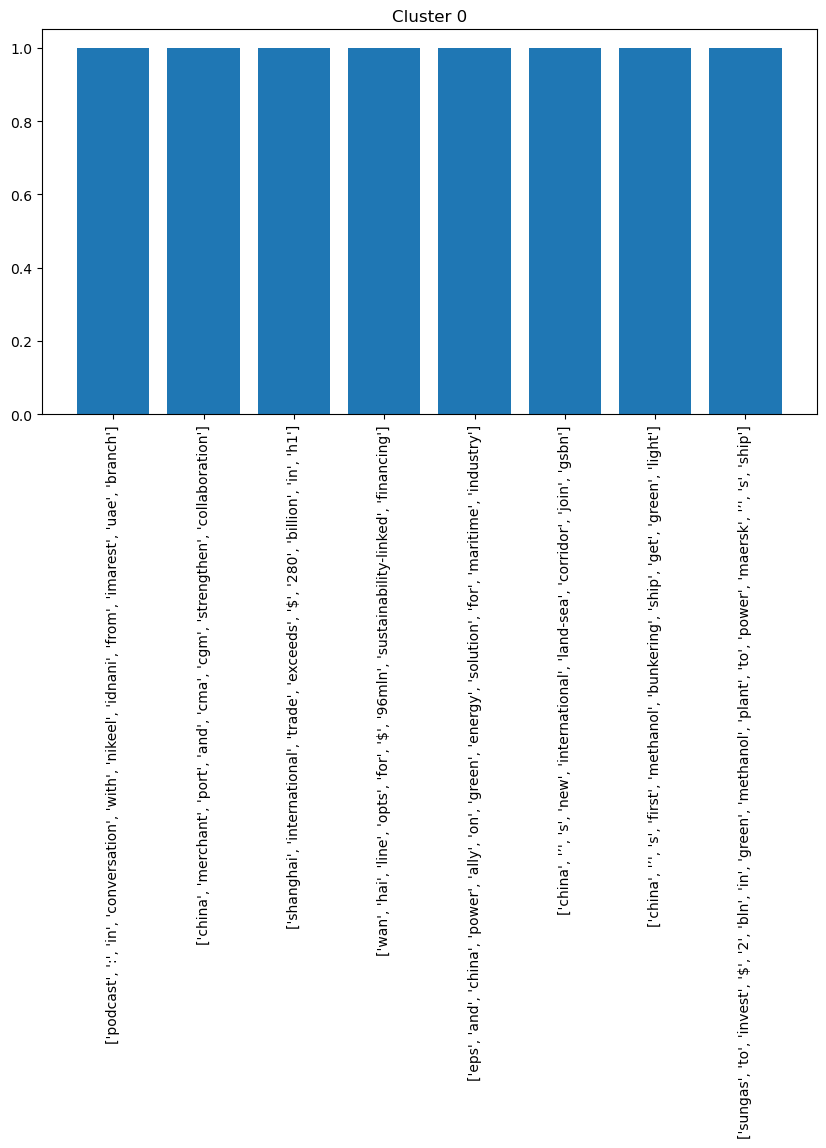

Cluster 1:
 - ['singapore', 'carry', 'out', 'first', 'ship-to-ship', 'methanol', 'bunkering', 'for', 'maersk']


ValueError: input operand has more dimensions than allowed by the axis remapping

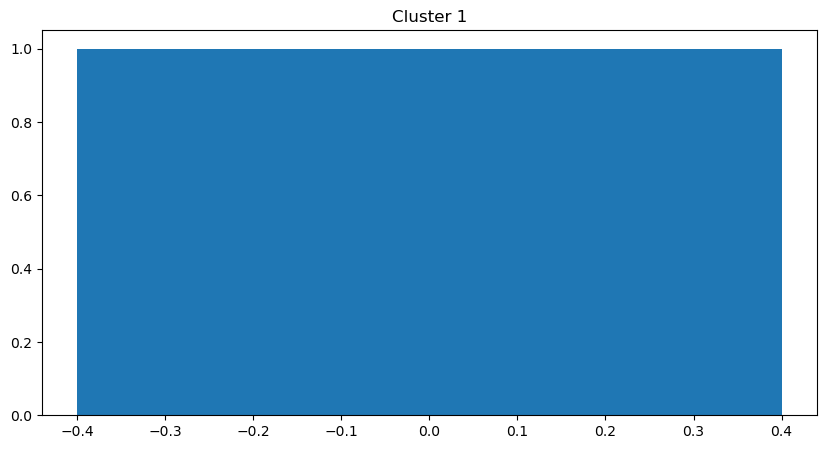

In [19]:
def visualize_clusters(filtered_df, clusters):
    cluster_data = {}
    for cluster_label, title in zip(clusters, filtered_df['Title']):
        if cluster_label not in cluster_data:
            cluster_data[cluster_label] = [title]
        else:
            cluster_data[cluster_label].append(title)

    for cluster_label, titles in cluster_data.items():
        print(f"Cluster {cluster_label}:")
        for title in titles:
            print(f" - {title}")

        # Visualize the cluster
        plt.figure(figsize=(10, 5))
        plt.title(f"Cluster {cluster_label}")
        plt.bar(range(len(titles)), [1] * len(titles), tick_label=titles)
        plt.xticks(rotation=90)
        plt.show()

# Call the visualization function
visualize_clusters(filtered_df, clusters)
